# 1. 2025년 10월 1일~5일 SNS_COMMUNITY DATA ANALYSIS

## (1) SNS 데이터 워드클라우드

### A. 필요 라이브러리 임포트

In [150]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### B. 데이터 로드 및 필터링

In [151]:
# 데이터 로드
df = pd.read_csv('./FINAL_SNS_YOUTUBE.csv', encoding='utf-8-sig')

print(f"전체 데이터: {len(df):,}행")
print(f"날짜 범위: {df['date'].min()} ~ {df['date'].max()}")
print(f"\n컬럼: {df.columns.tolist()}")

전체 데이터: 6,382행
날짜 범위: 20250901 ~ 20251031

컬럼: ['date', 'platform', 'type', 'content', 'engagement', 'author', 'url', 'original_date', 'id']


In [152]:
# 2025년 10월 1일~5일 데이터 필터링
start_date = 20251001
end_date = 20251005
df_oct5 = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

print(f"\n{'='*100}")
print(f"2025년 10월 1일~5일 SNS데이터")
print(f"{'='*100}")
print(f"SNS데이터수: {len(df_oct5):,}개")
print(f"\n샘플데이터:")
for i, content in enumerate(df_oct5['content'], 1):
    print(f"{i:2d}. {content}")


2025년 10월 1일~5일 SNS데이터
SNS데이터수: 80개

샘플데이터:
 1. Market Edge ANC 1 October 2025 Heres the news from Market Edge this October 1 2025 Headlines Asian Factory Activity Roundup Philippine Corporate News
 2. 03 October 2025 Market Analysis shorts Nifty showed a strong bullish move today As we shared earlier a Long trade following the market trend could have been taken
 3. Super Red Trade Recovery How I Avoid Panic Selling Near My Entry The Nightmare Scenario Down 3000 on a Single Trade Every trader has been there Youre in a super red trade perhaps
 4. Monthly Market Outlook October 2025 by Prateek Agrawal In this video we share our perspective on the Q1 FY25 results and the key market trends shaping the investment landscape
 5. All Vortex Blue Bot bot trading gather here LOL
 6. 100 leverage 2980 margin on a 298K size would put a shorts liq just above entry within 12 if isolated 2925 is 31 below entryimpossible for that short with that margin
 7. The central bank is addressing the inflation

In [153]:
# 모든 content를 하나의 문자열로 결합
all_content = ' '.join(df_oct5['content'].dropna().astype(str))

print(f"전체 텍스트 길이: {len(all_content):,}자")
print(f"\n전체 텍스트 샘플 (처음 500자):")
print(all_content[:500])

전체 텍스트 길이: 21,546자

전체 텍스트 샘플 (처음 500자):
Market Edge ANC 1 October 2025 Heres the news from Market Edge this October 1 2025 Headlines Asian Factory Activity Roundup Philippine Corporate News 03 October 2025 Market Analysis shorts Nifty showed a strong bullish move today As we shared earlier a Long trade following the market trend could have been taken Super Red Trade Recovery How I Avoid Panic Selling Near My Entry The Nightmare Scenario Down 3000 on a Single Trade Every trader has been there Youre in a super red trade perhaps Monthly 


### C. 단어 추출 및 정제(불용어 처리 등)

In [162]:
# 단어 추출 및 정제
# 영문 단어만 추출 (최소 3글자 이상)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 필수 리소스 다운로드 (이미 했으면 생략 가능)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 1. 단어 추출 (소문자 변환 후 정규식)
# all_content가 정의되어 있다고 가정
words = re.findall(r'\b[a-z]{3,}\b', all_content.lower())

# 2. 강력한 불용어 사전 구축
# NLTK 제공 기본 불용어 (i, me, my, myself, we, our... 등 수백 개 포함)
stop_words = set(stopwords.words('english'))

# 사용자 정의 불용어 (오타 수정 및 확장)
custom_stops = {
    # 오타 수정됨 (will, etf 사이 쉼표 등)
    'warpup', 'wrapup', 'wrap',
    'news', 'report', 'reports', 'reported', 'reporting',
    'analysis', 'analyst', 'analysts',
    'say', 'says', 'said', 'saying', 'according',
    'amid', 'update', 'updates', 'latest',
    'today', 'yesterday', 'tomorrow',
    'time', 'year', 'years', 'week', 'weeks', 'day', 'days', 'month', 'months',
    'people', 'investor', 'investors', 'trader', 'traders',
    'good', 'bad', 'new', 'old', 'great',
    'much', 'many', 'high', 'low', 'big', 'small',
    'million', 'billion',
    'hit', 'hits', 'rise', 'rises', 'rising', 'rose',
    'fall', 'falls', 'falling', 'fell',
    'surge', 'surges', 'surging',
    'drop', 'drops', 'dropping',
    'bitcoin', 'btc', 'crypto', 'cryptocurrency',
    'price', 'prices', 'pricing',
    'market', 'markets',
    'stock', 'stocks',
    'ethereum', 'xrp', 'gold',
    'etf', 'etfs',
    'mining', 'miner',
    'record', 'rally',
    'video', 'channel', 'subscribe', 'link',
    'thank', 'thanks',
    'got', 'get', 'getting',
    'now', 'one', 'use', 'make', 'see', 'look', 'watch',
    'like', 'know', 'think', 'going', 'would', 'could', 'should'
}

# 두 집합 합치기
stop_words.update(custom_stops)

# 3. 표제어 추출기(Lemmatizer) 준비
lemmatizer = WordNetLemmatizer()

# 4. 필터링 로직 개선 (핵심!)
# 단어를 원형으로 바꾼 뒤(lemmatize), 그 원형이 불용어 리스트에 있는지 확인합니다.
filtered_words = [
    word for word in words 
    if word not in stop_words  # 1차: 단어 그대로 확인
    and lemmatizer.lemmatize(word) not in stop_words # 2차: 원형으로 바꿔서 확인 (investors -> investor)
    and lemmatizer.lemmatize(word, pos='v') not in stop_words # 3차: 동사 원형 확인 (reported -> report)
]

print(f"------------ 결과 확인 ------------")
print(f"추출된 단어 수 (전): {len(words):,}개")
print(f"추출된 단어 수 (후): {len(filtered_words):,}개")
print(f"제거된 단어 수: {len(words) - len(filtered_words):,}개")
print(f"고유 단어 수: {len(set(filtered_words)):,}개")

# 상위 단어 확인해서 여전히 쓰레기 단어가 있는지 체크
from collections import Counter
print("\n[최종 상위 20개 단어]")
print(Counter(filtered_words).most_common(20))

------------ 결과 확인 ------------
추출된 단어 수 (전): 3,001개
추출된 단어 수 (후): 1,820개
제거된 단어 수: 1,181개
고유 단어 수: 1,089개

[최종 상위 20개 단어]
[('bonds', 24), ('bond', 23), ('real', 16), ('housing', 14), ('buy', 14), ('estate', 13), ('october', 12), ('back', 11), ('best', 10), ('treasuries', 10), ('construction', 9), ('sell', 8), ('portfolios', 8), ('risk', 8), ('model', 8), ('rate', 7), ('still', 7), ('money', 7), ('home', 7), ('rates', 7)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [163]:
# 단어 빈도 계산
word_counts = Counter(filtered_words)

print(f"\n{'='*60}")
print("상위 30개 단어")
print(f"{'='*60}")
for i, (word, count) in enumerate(word_counts.most_common(30), 1):
    print(f"{i:2d}. {word:20s} : {count:3d}회")


상위 30개 단어
 1. bonds                :  24회
 2. bond                 :  23회
 3. real                 :  16회
 4. housing              :  14회
 5. buy                  :  14회
 6. estate               :  13회
 7. october              :  12회
 8. back                 :  11회
 9. best                 :  10회
10. treasuries           :  10회
11. construction         :   9회
12. sell                 :   8회
13. portfolios           :   8회
14. risk                 :   8회
15. model                :   8회
16. rate                 :   7회
17. still                :   7회
18. money                :   7회
19. home                 :   7회
20. rates                :   7회
21. selling              :   6회
22. inflation            :   6회
23. calgary              :   6회
24. canada               :   6회
25. interest             :   6회
26. buyers               :   6회
27. want                 :   6회
28. government           :   6회
29. tips                 :   6회
30. treasury             :   6회


### D. 워드클라우드 생성

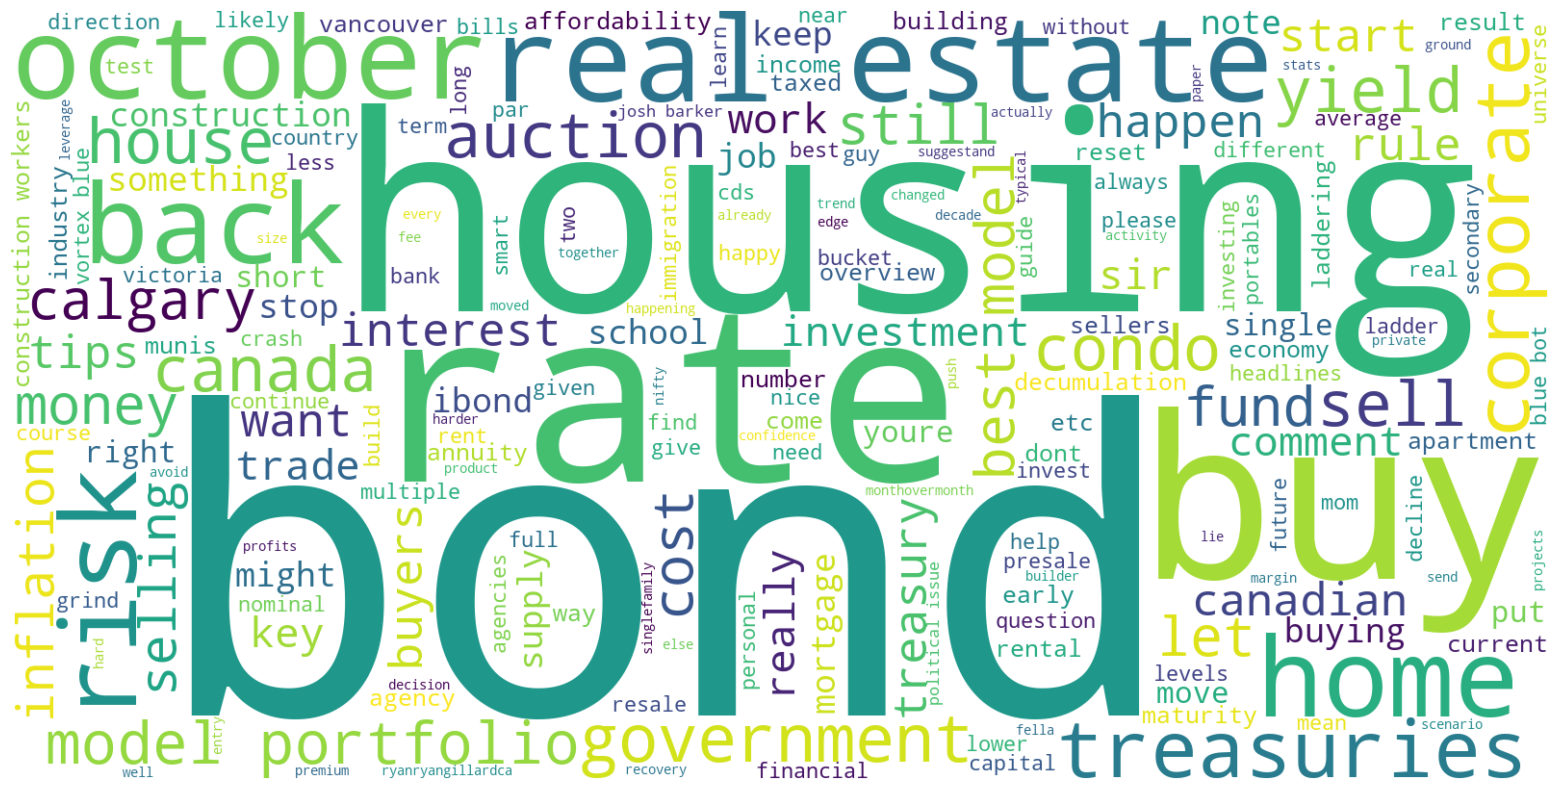

In [165]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

my_stop_words = set(stopwords.words('english'))

if 'custom_stops' in locals():
    my_stop_words.update(custom_stops)

# 3. 워드클라우드 생성
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10,
    max_words=200,
   
    stopwords=my_stop_words 
).generate(' '.join(filtered_words)) # filtered_words는 이미 리스트이므로 공백으로 합쳐서 문자열로 변환

# 4. 시각화
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 2. 2025년 10월 6일~11일 SNS_COMMUNITY DATA ANALYSIS

## (1) SNS 데이터 워드클라우드

In [157]:
# 2025년 10월 1일~5일 데이터 필터링
start_date_2 = 20251006
end_date_2 = 20251011
df_oct6 = df[(df['date'] >= start_date_2) & (df['date'] <= end_date_2)].copy()

print(f"\n{'='*100}")
print(f"2025년 10월 6일~11일 SNS데이터")
print(f"{'='*100}")
print(f"SNS데이터수: {len(df_oct6):,}개")
print(f"\n샘플데이터:")
for i_2, content in enumerate(df_oct6['content'], 1):
    print(f"{i_2:2d}. {content}")


2025년 10월 6일~11일 SNS데이터
SNS데이터수: 1,079개

샘플데이터:
 1. Market Edge ANC 6 October 2025 Heres the news from Market Edge this October 6 2025 Headlines PSEi Performance Analyst Expectations Todays Top
 2. Nice video and Thank you also for recommending Sarah Jennine Davis her services are exceptional and Ive been earning greatly from investing with her
 3. Why Ethereum is Still Strong Despite 20M Dump Ethereum just absorbed a 20 million selloff without flinching While whales offloaded ETH smaller investors stepped in proving
 4. Man she does great job and it is free Even broker support people are clueless and they have no idea what is going on may be too much to ask for
 5. You are assuming investors are piling into treasuries but you need to look at what the Fed is doing The Fed is buying longerterm treasuries to keep the yield down In other words they are expanding the money supply and causing future inflation to keep interest rates low They are printing money
 6. This is a lot of good info

### A. 데이터 로드 및 필터링

In [158]:
# 모든 content를 하나의 문자열로 결합
all_content_2 = ' '.join(df_oct6['content'].dropna().astype(str))

print(f"전체 텍스트 길이: {len(all_content_2):,}자")
print(f"\n전체 텍스트 샘플 (처음 500자):")
print(all_content_2[:500])

전체 텍스트 길이: 104,164자

전체 텍스트 샘플 (처음 500자):
Market Edge ANC 6 October 2025 Heres the news from Market Edge this October 6 2025 Headlines PSEi Performance Analyst Expectations Todays Top Nice video and Thank you also for recommending Sarah Jennine Davis her services are exceptional and Ive been earning greatly from investing with her Why Ethereum is Still Strong Despite 20M Dump Ethereum just absorbed a 20 million selloff without flinching While whales offloaded ETH smaller investors stepped in proving Man she does great job and it is free


### B. 단어 추출 및 정제(불용어 처리 등)

In [171]:
# 단어 추출 및 정제
# 영문 단어만 추출 (최소 3글자 이상)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. 단어 추출 (소문자 변환 후 정규식)
# all_content_2
words = re.findall(r'\b[a-z]{3,}\b', all_content_2.lower())

# 2. 강력한 불용어 사전 구축
# NLTK 제공 기본 불용어 (i, me, my, myself, we, our... 등 수백 개 포함)
stop_words_2 = set(stopwords.words('english'))

# 사용자 정의 불용어 (오타 수정 및 확장)
custom_stops_2 = {
    # 오타 수정됨 (will, etf 사이 쉼표 등)
    'warpup', 'wrapup', 'wrap',
    'news', 'report', 'reports', 'reported', 'reporting',
    'analysis', 'analyst', 'analysts',
    'say', 'says', 'said', 'saying', 'according',
    'amid', 'update', 'updates', 'latest',
    'today', 'yesterday', 'tomorrow',
    'time', 'year', 'years', 'week', 'weeks', 'day', 'days', 'month', 'months',
    'people', 'investor', 'investors', 'trader', 'traders',
    'good', 'bad', 'new', 'old', 'great',
    'much', 'many', 'high', 'low', 'big', 'small',
    'million', 'billion',
    'hit', 'hits', 'rise', 'rises', 'rising', 'rose',
    'fall', 'falls', 'falling', 'fell',
    'surge', 'surges', 'surging',
    'drop', 'drops', 'dropping',
    'bitcoin', 'btc', 'crypto', 'cryptocurrency',
    'price', 'prices', 'pricing',
    'market', 'markets',
    'stock', 'stocks',
    'ethereum', 'xrp', 'gold',
    'etf', 'etfs',
    'mining', 'miner',
    'record', 'rally',
    'video', 'channel', 'subscribe', 'link',
    'thank', 'thanks',
    'got', 'get', 'getting',
    'now', 'one', 'use', 'make', 'see', 'look', 'watch',
    'like', 'know', 'think', 'going', 'would', 'could', 'should', 'hai'
}

# 두 집합 합치기
stop_words_2.update(custom_stops_2)

# 3. 표제어 추출기(Lemmatizer) 준비
lemmatizer_2 = WordNetLemmatizer()

# 4. 필터링 로직 개선 (핵심!)
# 단어를 원형으로 바꾼 뒤(lemmatize), 그 원형이 불용어 리스트에 있는지 확인합니다.
filtered_words_2 = [
    word for word in words 
    if word not in stop_words_2  # 1차: 단어 그대로 확인
    and lemmatizer_2.lemmatize(word) not in stop_words_2 # 2차: 원형으로 바꿔서 확인 (investors -> investor)
    and lemmatizer_2.lemmatize(word, pos='v') not in stop_words_2 # 3차: 동사 원형 확인 (reported -> report)
]

print(f"------------ 결과 확인 ------------")
print(f"추출된 단어 수 (전): {len(words):,}개")
print(f"추출된 단어 수 (후): {len(filtered_words_2):,}개")
print(f"제거된 단어 수: {len(words) - len(filtered_words_2):,}개")
print(f"고유 단어 수: {len(set(filtered_words_2)):,}개")

# 상위 단어 확인해서 여전히 쓰레기 단어가 있는지 체크
from collections import Counter
print("\n[최종 상위 20개 단어]")
print(Counter(filtered_words_2).most_common(20))

------------ 결과 확인 ------------
추출된 단어 수 (전): 14,499개
추출된 단어 수 (후): 9,675개
제거된 단어 수: 4,824개
고유 단어 수: 3,982개

[최종 상위 20개 단어]
[('crash', 172), ('october', 88), ('trump', 59), ('buy', 54), ('manipulation', 54), ('liquidation', 50), ('discussion', 48), ('biggest', 39), ('leverage', 36), ('trading', 34), ('money', 32), ('technical', 32), ('que', 32), ('sir', 30), ('breakdown', 30), ('binance', 30), ('tha', 30), ('liquidated', 29), ('experience', 28), ('community', 27)]


In [172]:
# 단어 빈도 계산
word_counts_2 = Counter(filtered_words_2)

print(f"\n{'='*60}")
print("상위 30개 단어")
print(f"{'='*60}")
for i_2, (word_2, count_2) in enumerate(word_counts_2.most_common(30), 1):
    print(f"{i_2:2d}. {word_2:20s} : {count_2:3d}회")


상위 30개 단어
 1. crash                : 172회
 2. october              :  88회
 3. trump                :  59회
 4. buy                  :  54회
 5. manipulation         :  54회
 6. liquidation          :  50회
 7. discussion           :  48회
 8. biggest              :  39회
 9. leverage             :  36회
10. trading              :  34회
11. money                :  32회
12. technical            :  32회
13. que                  :  32회
14. sir                  :  30회
15. breakdown            :  30회
16. binance              :  30회
17. tha                  :  30회
18. liquidated           :  29회
19. experience           :  28회
20. community            :  27회
21. reaction             :  27회
22. event                :  26회
23. largest              :  26회
24. back                 :  25회
25. personal             :  24회
26. history              :  24회
27. dump                 :  23회
28. real                 :  23회
29. short                :  23회
30. sell                 :  23회


### C. 워드클라우드 생성

✓ 워드클라우드 저장 완료: ./wordcloud_analysis/wordcloud_20251006_20251011.png


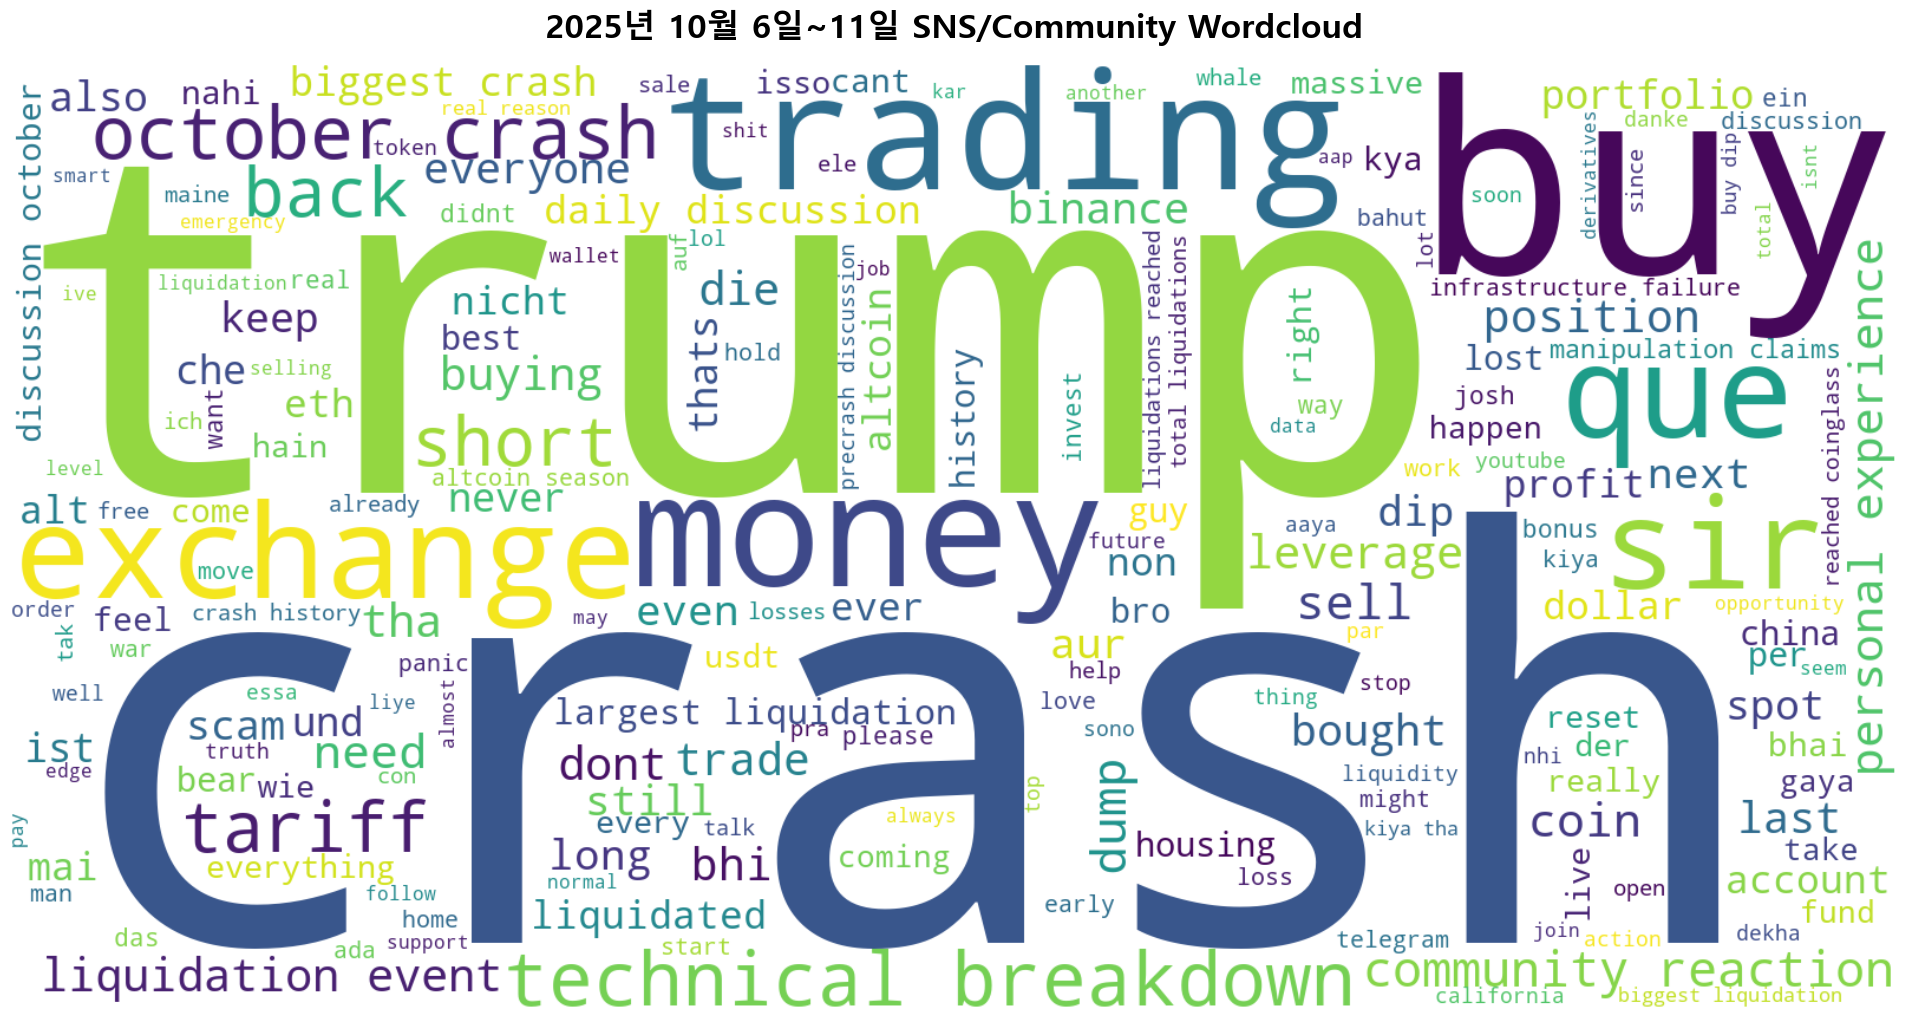

In [173]:
from nltk.corpus import stopwords  # NLTK 도구
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# NLTK 도구에서 'english' 단어장
final_stop_words = set(stopwords.words('english'))

# 사용자 정의 불용어(custom_stops_2) 합치기
if 'custom_stops' in locals():
    final_stop_words.update(custom_stops_2)

# 3. 워드클라우드 생성
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10,
    max_words=200,
    # 🚨 수정된 부분: stopwords 변수 대신 우리가 만든 final_stop_words를 넣습니다.
    stopwords=final_stop_words 
).generate(' '.join(filtered_words_2))

# 4. 시각화
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('2025년 10월 6일~11일 SNS/Community Wordcloud', 
          fontsize=24, fontweight='bold', pad=20)
plt.tight_layout(pad=0)

# 5. 이미지 저장 (폴더가 없으면 에러나므로 확인)
import os
os.makedirs('./wordcloud_analysis', exist_ok=True) # 폴더 자동 생성

output_path = './wordcloud_analysis/wordcloud_20251006_20251011.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ 워드클라우드 저장 완료: {output_path}")

plt.show()